In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV, validation_curve, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, f1_score, plot_confusion_matrix, accuracy_score, \
    plot_roc_curve, plot_precision_recall_curve, classification_report, precision_score, recall_score
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [58]:
# загружаем данные полученные в EDA+FE
data_mod = pd.read_csv('mod_data/data_mod.csv')
submission = pd.read_csv('data/sample_submission.csv')

In [59]:
# датафрейм для записи результатов
report_df = pd.DataFrame()

def get_scores(report_df, model, X_test, y_test, name):
    '''Принимает на вход датафрейм, обученную модель и данные с отложенной выборки, 
    рассчитывает метрики и записывает результаты в датафрейм'''
    report = pd.DataFrame(columns={'ROC-AUC'}, data=[0])
    report['ROC-AUC'] = roc_auc_score(y_test,
                                      model.predict_proba(X_test)[:, 1])
    report['F1'] = f1_score(y_test, model.predict(X_test))
    report['precision_0'] = precision_score(
        y_test, model.predict(X_test), pos_label=0)
    report['precision_1'] = precision_score(
        y_test, model.predict(X_test), pos_label=1)
    report['recall_0'] = recall_score(
        y_test, model.predict(X_test), pos_label=0)
    report['recall_1'] = recall_score(
        y_test, model.predict(X_test), pos_label=1)
    report['accuracy'] = accuracy_score(
        y_test, model.predict(X_test))
    report.index = [name]
    report_df = report_df.append(report)
    return report_df

# Feature selection

In [60]:
data_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PassengerId  200000 non-null  int64  
 1   Survived     100000 non-null  float64
 2   Pclass       200000 non-null  int64  
 3   Name         200000 non-null  object 
 4   Sex          200000 non-null  object 
 5   Age          200000 non-null  float64
 6   SibSp        200000 non-null  int64  
 7   Parch        200000 non-null  int64  
 8   Ticket       200000 non-null  object 
 9   Fare         200000 non-null  float64
 10  Embarked     200000 non-null  object 
 11  Deck         200000 non-null  object 
 12  Family       200000 non-null  int64  
 13  Alone        200000 non-null  bool   
 14  FareC        200000 non-null  object 
 15  AgeC         200000 non-null  object 
dtypes: bool(1), float64(3), int64(5), object(7)
memory usage: 23.1+ MB


In [61]:
data = data_mod[['Survived', 'Age', 'Fare', 'Family', 'Pclass', 'Sex', 'Embarked', 'Deck', 'Alone', 'Name', 'Ticket']]

# Features encoding

In [62]:
features_encoding = ['Pclass','Sex','Embarked','Deck','Alone'] 
data = pd.get_dummies(data=data, columns=features_encoding)

In [63]:
features_encoding  = ['Family', 'Name', 'Ticket']
for i in features_encoding:
    data[i] = LabelEncoder().fit_transform(data[i])

In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 25 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Survived     100000 non-null  float64
 1   Age          200000 non-null  float64
 2   Fare         200000 non-null  float64
 3   Family       200000 non-null  int64  
 4   Name         200000 non-null  int64  
 5   Ticket       200000 non-null  int64  
 6   Pclass_1     200000 non-null  uint8  
 7   Pclass_2     200000 non-null  uint8  
 8   Pclass_3     200000 non-null  uint8  
 9   Sex_female   200000 non-null  uint8  
 10  Sex_male     200000 non-null  uint8  
 11  Embarked_C   200000 non-null  uint8  
 12  Embarked_Q   200000 non-null  uint8  
 13  Embarked_S   200000 non-null  uint8  
 14  Deck_A       200000 non-null  uint8  
 15  Deck_B       200000 non-null  uint8  
 16  Deck_C       200000 non-null  uint8  
 17  Deck_D       200000 non-null  uint8  
 18  Deck_E       200000 non-

### Split data

In [65]:
# разделяем общий дадасет data на train и test
# в тестовый датасет попадают только те объекты для которых значение 'Survived' не определено
predict_data = data[data['Survived'].isnull()]
predict_data = predict_data.drop(['Survived'], axis = 1)

# в тренировачный набор попадают объекты у которых нет пропущеных значений ни у одной переменной
train_data = data.dropna()
target = train_data['Survived']
train_data = train_data.drop(['Survived'], axis = 1)
# контроль разммера
train_data.shape

(100000, 24)

# Random Forest model

In [66]:
from sklearn.ensemble import RandomForestClassifier

In [67]:
# разделяем на отложенную и ообучающую
X_train, X_test, y_train, y_test = train_test_split(train_data, target, 
                                                    test_size=0.2, 
                                                    random_state=23)

In [68]:
rf = RandomForestClassifier()
rf_params = {
    'bootstrap': [True,False],
    'n_estimators': [600,1000,2000,3000],
    'min_samples_split': [2,3,5,7],
    'min_samples_leaf': [8,10,12]
}
# подбор гиперпараметров
rf_rand = RandomizedSearchCV(rf, rf_params, cv=3, refit=True, verbose=5, n_jobs=-1, n_iter=20, random_state=54)
rf_rand.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 25.5min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'min_samples_leaf': [8, 10, 12],
                                        'min_samples_split': [2, 3, 5, 7],
                                        'n_estimators': [600, 1000, 2000,
                                                         3000]},
                   random_state=54, verbose=5)

In [69]:
# лучший score и лучшие параметры на кросс-валидации
print("Accuracy (random forest auto): {} params {}"
      .format(rf_rand.best_score_, rf_rand.best_params_))
# записываем результаты на отложенной выборке в датафрейм
report_df = get_scores(report_df, rf_rand, X_test,
                       y_test, 'Random_Forest')

Accuracy (random forest auto): 0.7789624921183274 params {'n_estimators': 1000, 'min_samples_split': 3, 'min_samples_leaf': 12, 'bootstrap': True}


In [70]:
report_df

,ROC-AUC,F1,precision_0,precision_1,recall_0,recall_1,accuracy
Random_Forest,0.85463,0.747314,0.806233,0.757783,0.822762,0.73713,0.786


# Logistic Regression model

In [71]:
from sklearn.linear_model import LogisticRegression

In [72]:
X_train, X_test, y_train, y_test = train_test_split(train_data, target, 
                                                    test_size=0.2, 
                                                    random_state=23)

In [73]:
lr = LogisticRegression()
lr_params = {
    'C': np.linspace(0.001, 10, 20), 
    'penalty': ['l1', 'l2']
}
# подбор гиперпараметров
lr_rand = RandomizedSearchCV(lr, lr_params, cv=5, refit=True, verbose=5, n_jobs=-1, n_iter=20, random_state=54)
lr_rand.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.2s finished


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20, n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-03, 5.27263158e-01, 1.05352632e+00, 1.57978947e+00,
       2.10605263e+00, 2.63231579e+00, 3.15857895e+00, 3.68484211e+00,
       4.21110526e+00, 4.73736842e+00, 5.26363158e+00, 5.78989474e+00,
       6.31615789e+00, 6.84242105e+00, 7.36868421e+00, 7.89494737e+00,
       8.42121053e+00, 8.94747368e+00, 9.47373684e+00, 1.00000000e+01]),
                                        'penalty': ['l1', 'l2']},
                   random_state=54, verbose=5)

In [75]:
# лучший score и лучшие параметры на кросс-валидации
print("Accuracy (random forest auto): {} params {}"
      .format(lr_rand.best_score_, lr_rand.best_params_))
# записываем результаты на отложенной выборке в датафрейм
report_df = get_scores(report_df, lr_rand, X_test,
                       y_test, 'Logistic_Regression')

Accuracy (random forest auto): 0.7646 params {'penalty': 'l2', 'C': 8.947473684210527}


In [76]:
report_df

,ROC-AUC,F1,precision_0,precision_1,recall_0,recall_1,accuracy
Random_Forest,0.854630,0.747314,0.806233,0.757783,0.822762,0.737130,0.78600
Logistic_Regression,0.840523,0.716046,0.774500,0.764581,0.844051,0.673305,0.77075


# LightGBM model

In [77]:
import lightgbm as lgb
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

In [78]:
X_train, X_test, y_train, y_test = train_test_split(train_data, target, 
                                                    test_size=0.2, 
                                                    random_state=23)

In [79]:
lgbc = lgb.LGBMClassifier()
lgbc_params = {
            'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
             'scale_pos_weight':[1,2,6,12],
             'metric':['binary_logloss']
}
lgbc_rand = RandomizedSearchCV(lgbc, lgbc_params, cv=5, refit=True, verbose=5, n_jobs=-1, n_iter=20, random_state=54, scoring = 'balanced_accuracy')
lgbc_rand.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.4s finished


RandomizedSearchCV(cv=5, estimator=LGBMClassifier(), n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff9e4a75f70>,
                                        'metric': ['binary_logloss'],
                                        'min_child_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff9e4ab6160>,
                                        'min_child_weight': [1e-05, 0.001, 0.01,
                                                             0.1, 1, 10.0,
                                                             100.0, 1000.0,
                                                             10000.0],
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff9e4ab6370>,
                                        'reg_alpha': [0, 0.1, 1, 2, 5, 7, 10,
                                                      50, 100],
                   

In [81]:
# лучший score и параметры на кросс-валидации
print("Accuracy (random forest auto): {} params {}"
      .format(lgbc_rand.best_score_, lgbc_rand.best_params_))
# записываем результаты на отложенной выборке в датафрейм
report_df = get_scores(report_df, lgbc_rand, X_test,
                       y_test, 'LGBM')

Accuracy (random forest auto): 0.7756251509337672 params {'colsample_bytree': 0.5137786086305816, 'metric': 'binary_logloss', 'min_child_samples': 379, 'min_child_weight': 0.1, 'num_leaves': 7, 'reg_alpha': 1, 'reg_lambda': 50, 'scale_pos_weight': 1, 'subsample': 0.3402885511705539}


In [82]:
report_df

,ROC-AUC,F1,precision_0,precision_1,recall_0,recall_1,accuracy
Random_Forest,0.854630,0.747314,0.806233,0.757783,0.822762,0.737130,0.78600
Logistic_Regression,0.840523,0.716046,0.774500,0.764581,0.844051,0.673305,0.77075
LGBM,0.854139,0.752494,0.813336,0.753769,0.815402,0.751223,0.78785


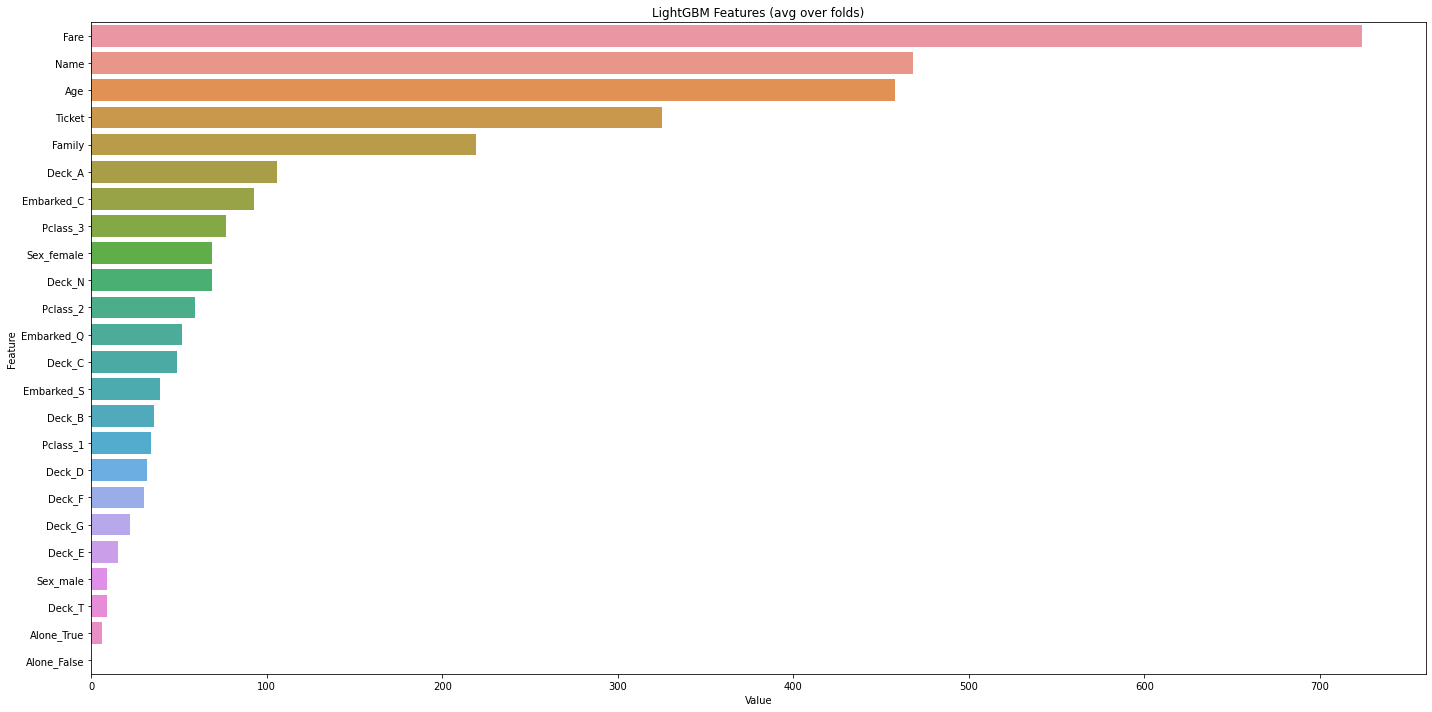

<Figure size 432x288 with 0 Axes>

In [44]:
#sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(lgbm_.feature_importances_,X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

# Stacking

In [83]:
from sklearn.ensemble import VotingClassifier

In [85]:
lgbm_ = lgb.LGBMClassifier(
    colsample_bytree=0.5904567583811636,
    metric='binary_logloss',
    min_child_samples= 365,
    min_child_weight= 0.1,
    num_leaves= 39,
    reg_alpha= 2,
    reg_lambda= 100,
    scale_pos_weight= 1,
    subsample= 0.735219247315511
)

rf_ = RandomForestClassifier(
    n_estimators= 1000, 
    min_samples_split= 3, 
    min_samples_leaf= 12, 
    bootstrap= True
)

lr_ = LogisticRegression(
    penalty='l2', 
    C=8.947
)

clf_st = VotingClassifier(estimators=[
    ('lr', lr_), ('rf', rf_), ('lgb', lgbm_)], voting='soft')

clf_st.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=8.947)),
                             ('rf',
                              RandomForestClassifier(min_samples_leaf=12,
                                                     min_samples_split=3,
                                                     n_estimators=1000)),
                             ('lgb',
                              LGBMClassifier(colsample_bytree=0.5904567583811636,
                                             metric='binary_logloss',
                                             min_child_samples=365,
                                             min_child_weight=0.1,
                                             num_leaves=39, reg_alpha=2,
                                             reg_lambda=100, scale_pos_weight=1,
                                             subsample=0.735219247315511))],
                 voting='soft')

In [87]:
# записываем результаты в датафрейм
report_df = get_scores(report_df, clf_st, X_test,
                       y_test, 'VotingClassifier')

In [88]:
report_df

,ROC-AUC,F1,precision_0,precision_1,recall_0,recall_1,accuracy
Random_Forest,0.854630,0.747314,0.806233,0.757783,0.822762,0.737130,0.78600
Logistic_Regression,0.840523,0.716046,0.774500,0.764581,0.844051,0.673305,0.77075
LGBM,0.854139,0.752494,0.813336,0.753769,0.815402,0.751223,0.78785
VotingClassifier,0.854919,0.744037,0.801953,0.760365,0.827317,0.728395,0.78485


In [49]:
# делаем прогноз лучшей моделью
pred = lgbc_rand.predict_proba(predict_data)

In [51]:
# отправляем посылку на Кегл
submission['Survived'] = ((pred) < 0.5).astype(int)
submission.to_csv('predict.csv', index = False)